INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


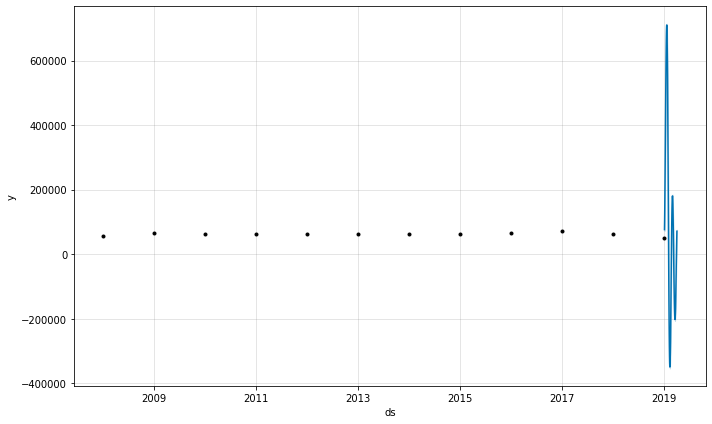

In [1]:
import pandas as pd
from time import time
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from fbprophet import Prophet
from pandas.core.frame import DataFrame

#    Unnamed: 0  국가  2008년  2009년  2010년  2011년  2012년  2013년  2014년  2015년  2016년  2017년  2018년  2019년
# 0          43  미국  62392  69124  75065  72153  73351  72295  70627  68105  63710  61007  58663  54555
# 1          17  중국  57504  66806  64232  62957  62855  63488  63465  62923  66672  73240  63827  50600
# 2          16  일본  17274  18862  27965  25692  19994  18919  17283  16374  15279  15457  15740  17012
# 3          87  호주  16774  18150  17829  33929  17256  14180  14139  14303  16251  16770  16801  18766
# 4          71  영국  17000  17031  17275  17310  12580  12512   7062  13002  11885  11065  10717  11903

foreign_df = pd.read_csv('./data/foreign_student.csv')
foreign_df = foreign_df.drop(foreign_df.columns[0: 2], axis=1)
foreign_df = foreign_df.reindex(sorted(foreign_df.columns), axis=1)

ds = *[f"{yy[:-1]}" for yy in foreign_df.columns],

us_df = foreign_df.loc[0]
cn_df = foreign_df.loc[1]
jp_df = foreign_df.loc[2]
at_df = foreign_df.loc[3]
en_df = foreign_df.loc[4]

us_dataset = pd.DataFrame({'ds': ds, 'y': [*list(us_df)]})
cn_dataset = pd.DataFrame({'ds': ds, 'y': [*list(cn_df)]})
jp_dataset = pd.DataFrame({'ds': ds, 'y': [*list(jp_df)]})
at_dataset = pd.DataFrame({'ds': ds, 'y': [*list(at_df)]})
en_dataset = pd.DataFrame({'ds': ds, 'y': [*list(en_df)]})

h1n1_df = pd.read_csv('./data/H1N1_preprocess.csv') # 신종플루 2009
mers_df = pd.read_csv('./data/MERS_preprocess.csv') # 메르스 2015

holiday_h1ni = pd.DataFrame({
  'holiday': 'h1n1',
  'ds': pd.to_datetime(['2009-01-01']),
  'lower_window': 0,
  'upper_window': 365,
  'prior_scale': 40
})

holiday_mers = pd.DataFrame({
  'holiday': 'mers',
  'ds': pd.to_datetime(['2015-01-01']),
  'lower_window': 0,
  'upper_window': 365,
  'prior_scale': 20
})

diseases = pd.concat([holiday_h1ni, holiday_mers])

series = [us_dataset, cn_dataset, jp_dataset, at_dataset, en_dataset]

def build_model(timeserie: DataFrame) -> Prophet:
  global diseases
  model = Prophet(holidays=diseases)
  model.fit(timeserie)
  return model

# start_time = time()
# p = Pool(cpu_count() - 1)
# predictions = list(tqdm(p.imap(build_model, series), total=len(series)))
# p.close()
# p.join()
# print("--- %s seconds ---" % (time() - start_time))

model = build_model(series[1])

forecast = model.make_future_dataframe(periods=90, include_history=False)
forecast = model.predict(forecast)
model_plt = model.plot(forecast, uncertainty=True)

forecast.head()
# COVID-19 - https://www.kaggle.com/imdevskp/corona-virus-report
# MERS - https://www.kaggle.com/imdevskp/mers-outbreak-dataset-20122019
# Ebola Western Africa 2014 Outbreak - https://www.kaggle.com/imdevskp/ebola-outbreak-20142016-complete-dataset
# H1N1 | Swine Flu 2009 Pandemic Dataset - https://www.kaggle.com/imdevskp/h1n1-swine-flu-2009-pandemic-dataset
# SARS 2003 Pandemic - https://www.kaggle.com/imdevskp/sars-outbreak-2003-complete-dataset
# HIV AIDS - https://www.kaggle.com/imdevskp/hiv-aids-dataset